In [25]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from keras.datasets import mnist
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

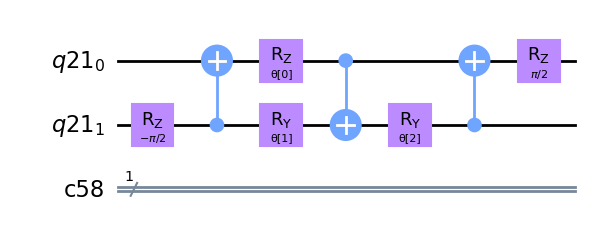

In [84]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumRegister(2)
    clbits = ClassicalRegister(1)
    target = QuantumCircuit(target, clbits)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

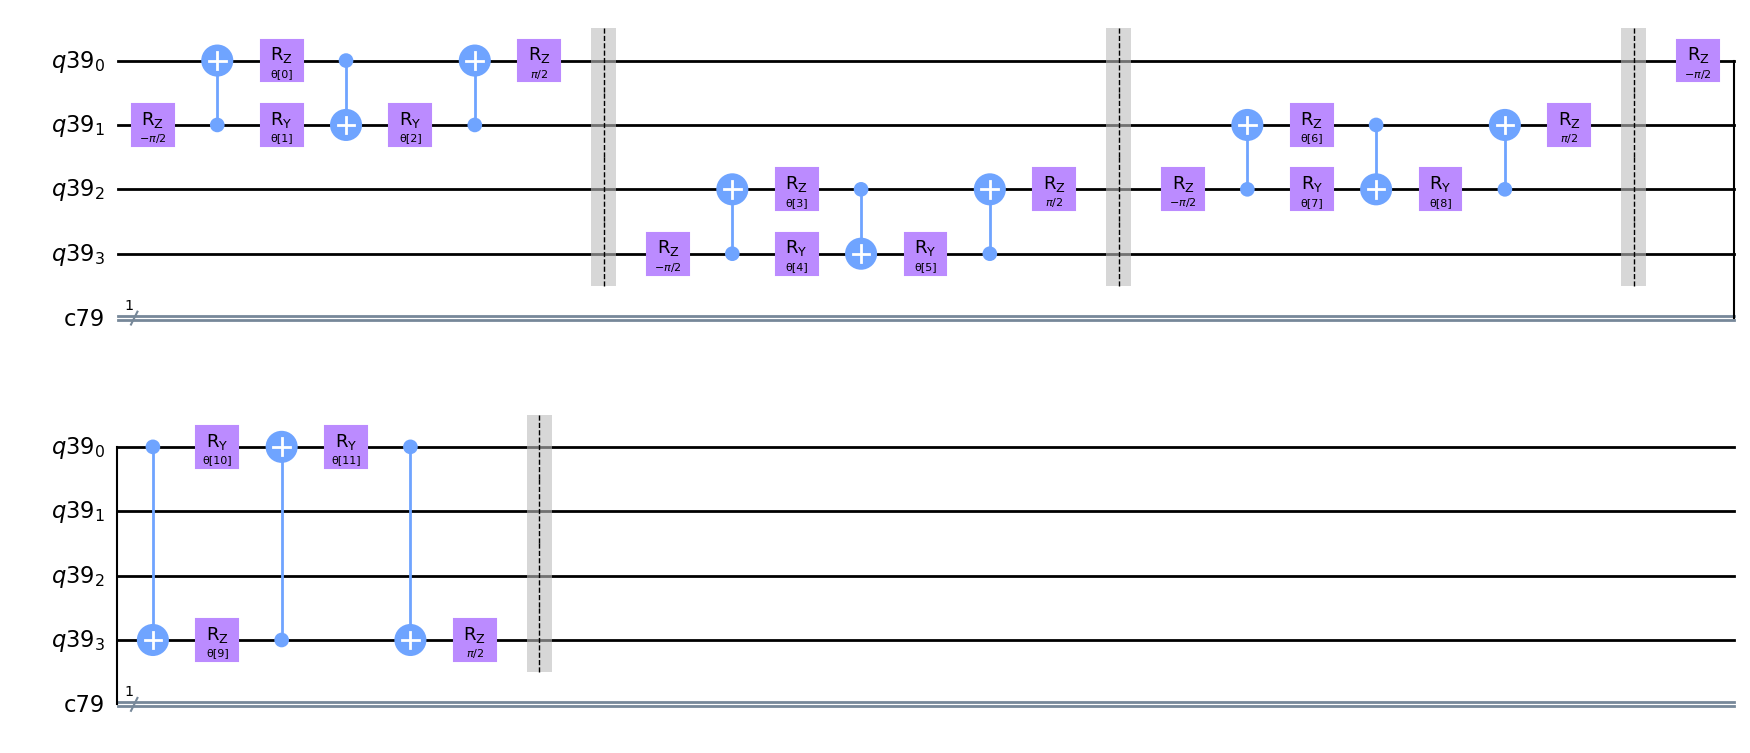

In [88]:
def conv_layer(num_qubits, param_prefix):
    target = QuantumRegister(num_qubits, name="Convolutional Layer")
    clbits = ClassicalRegister(1)
    qc = QuantumCircuit(target, clbits)
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    target = QuantumRegister(num_qubits)
    clbits = ClassicalRegister(1)
    qc = QuantumCircuit(target, clbits)
    qc.append(qc_inst, qubits, clbits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

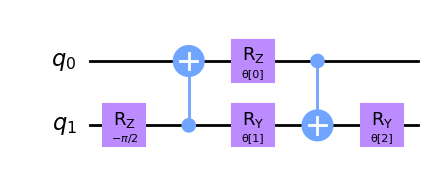

In [39]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target



params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

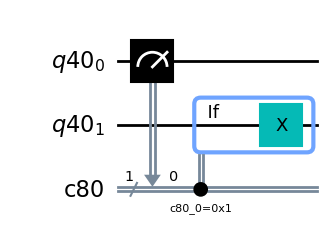

In [89]:
def pool_circuit(params):
    """
    target = QuantumCircuit(2)
    clbits = ClassicalRegister(1)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target
    """
    qubits = QuantumRegister(2)
    clbits = ClassicalRegister(1)
    target = QuantumCircuit(qubits, clbits)
    (q0,q1,) = qubits
    (c0,) = clbits
    target.measure(q0, c0)
    with target.if_test((c0, 1)):
        target.x(q1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

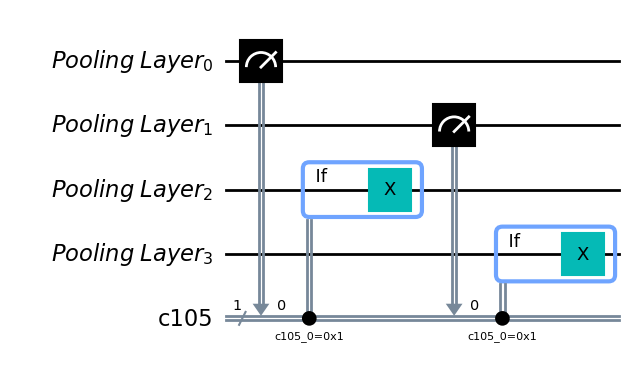

In [102]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qubits = QuantumRegister(num_qubits, name="Pooling Layer")
    clbits = ClassicalRegister(1)
    target = QuantumCircuit(qubits, clbits)
    (c0,) = clbits
    for i in range(num_qubits//2):
        target.measure(qubits[i],c0)
        with target.if_test((c0, 1)):
            target.x(qubits[i+num_qubits//2])
    """
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    clbits = ClassicalRegister(num_qubits//2)
    target = QuantumCircuit(qc, clbits)
    qubits = qc
    classical_bits = clbits
    for i in range(qubits/2):
        target.measure(qubits[2*i], classical_bits[i])
        with target.if_test((classical_bits[i], 1)):
            target.x(qubits[2*i+1])
    """

    

    return target


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

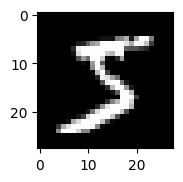

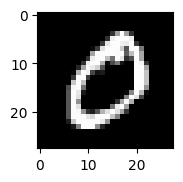

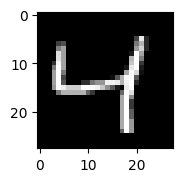

In [138]:
(train_images, test_images), (train_labels, test_labels) = mnist.load_data()
from matplotlib import pyplot
for i in range(3):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(train_images[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

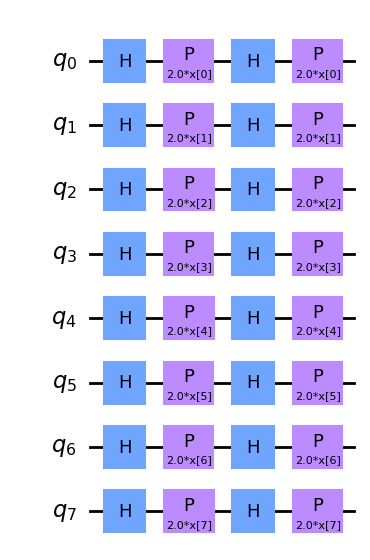

In [106]:
feature_map = ZFeatureMap(1024)

In [174]:
#TODO: Put together circuit with 1024 qubits
#Should follow this general formula:
"""
ansatz.compose(conv_layer(1024, "c1"), list(range(1024)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0,...,512], [513,...,1024], "p1"), list(range(1024)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(512, "c2"), list(range(512, 1024)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0,...,252], [257,...,512], "p2"), list(range(512, 1024)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(256, "c3"), list(range(768, 1024)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0,...,128], [129,...256], "p3"), list(range(768, 1024)), inplace=True)
"""

size = 1024

feature_map = ZFeatureMap(size)

ansatz = QuantumCircuit(size, name="Ansatz")

steps = 0
while size > 0:
    print(size)
    ansatz.compose(conv_layer(size, f"c{steps+1}"), list(range(int(size*(1-(1/(2**steps)))),size)), inplace=True)
    ansatz.compose(pool_layer(list(range(size//2)),list(range(size//2,size)), f"p{steps+1}"), list(range(int(size*(1-(1/(2**steps)))),size)), inplace=True)
    size = size // 2
    steps += 1

# Combining the feature map and ansatz
circuit = QuantumCircuit(1024)
circuit.compose(feature_map, range(1024), inplace=True)
circuit.compose(ansatz, range(1024), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 1023, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

1024
512


CircuitError: 'Number of items in qubits parameter (256) does not match number of qubits in the circuit (512).'

/Users/samuellurvey/Documents/QRise-Project/.venv/lib/python3.12/site-packages/qiskit/circuit/quantumcircuit.py:1800: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


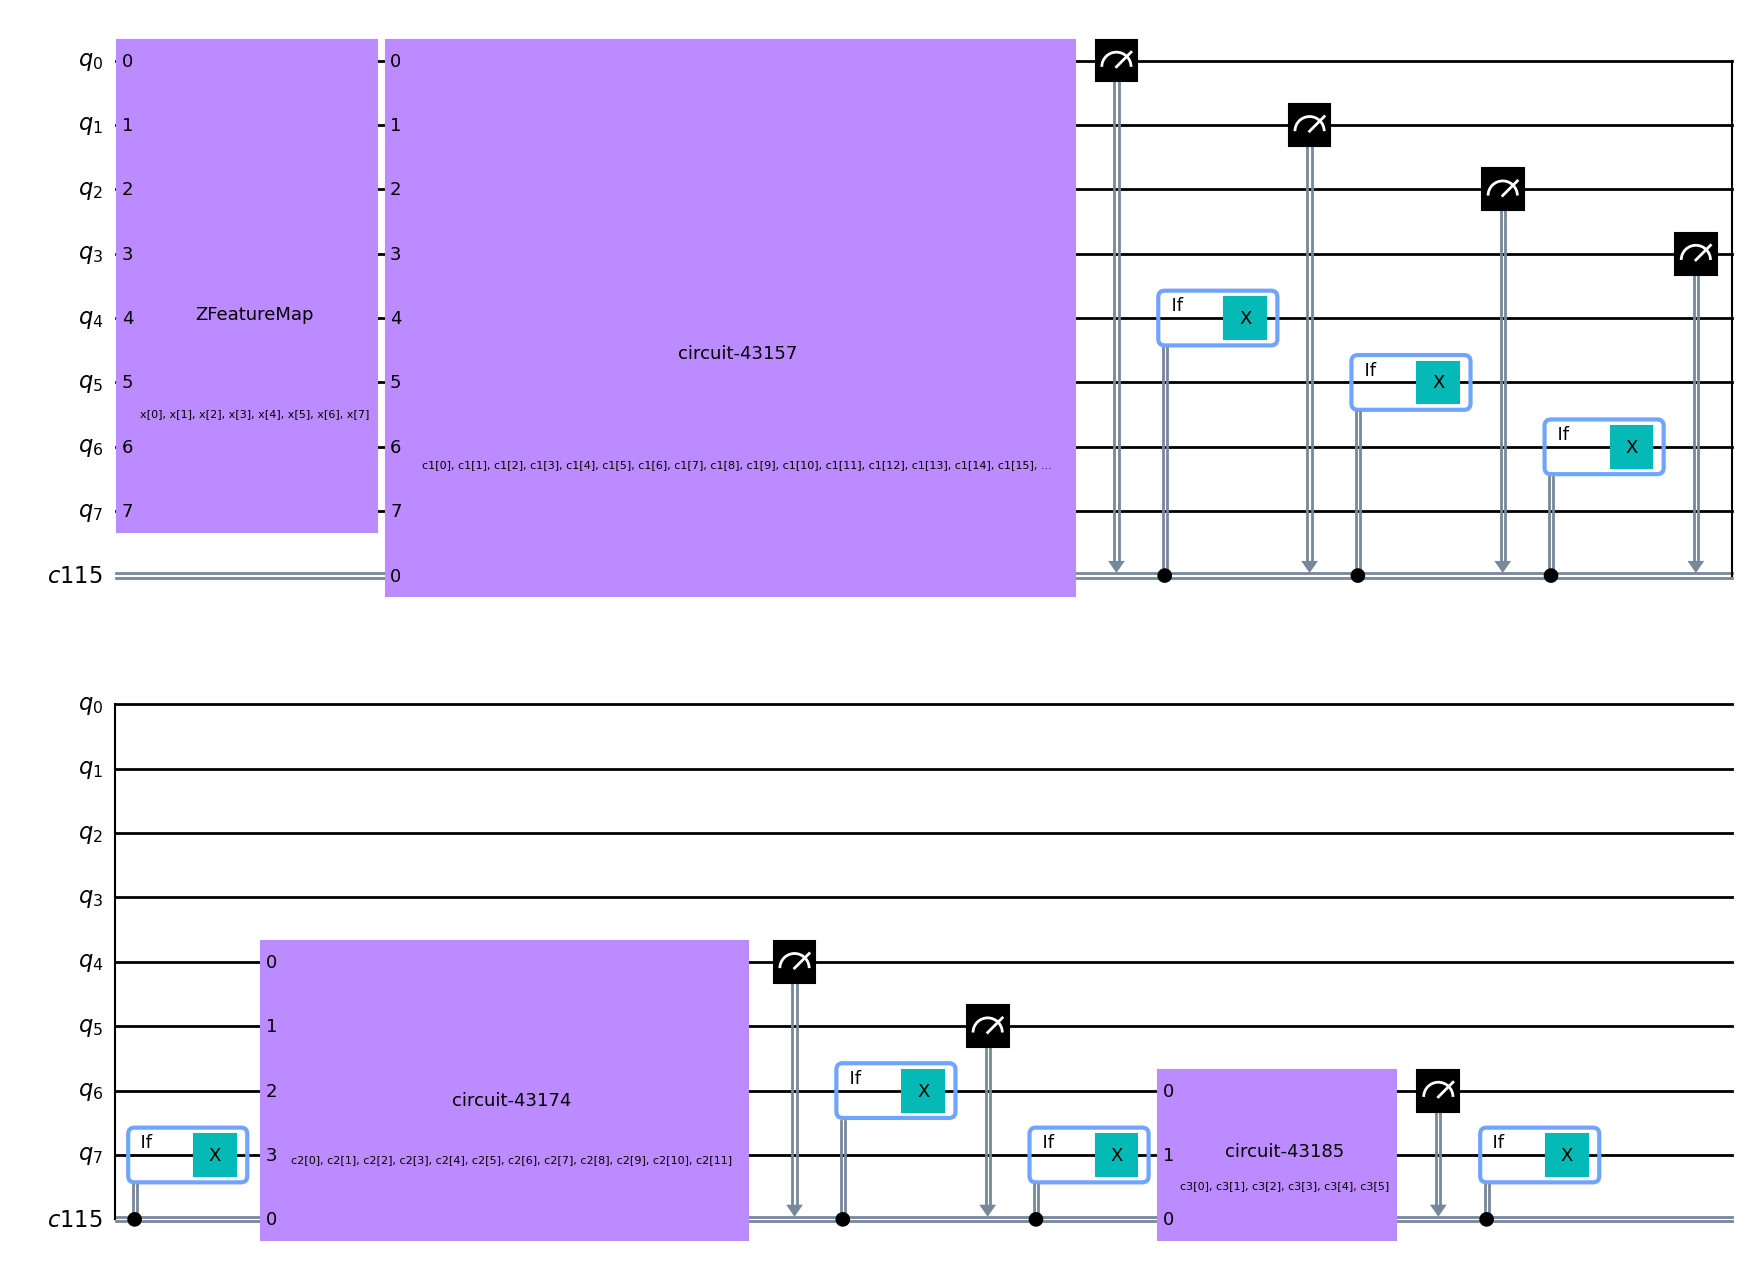

In [108]:
circuit.draw("mpl", style="clifford")

In [97]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [98]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=1000),  # Set max iterations here
    callback=callback_graph,
)

In [100]:
#TODO: get this shit working

x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

QiskitMachineLearningError: 'Estimator job failed.'

In [101]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

QiskitMachineLearningError: 'The model has not been fitted yet'